In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

In [2]:
# Download 1 year of hourly BTC data
btc = yf.download("BTC-USD", period="1y", interval="1h")

# Clean and prepare
btc = btc.asfreq('H').fillna(method='ffill')
btc["log_return"] = np.log(btc["Close"] / btc["Close"].shift(1))
btc.dropna(inplace=True)

btc.tail()

C:\Users\Muhammad Rengga\AppData\Local\Temp\ipykernel_24496\2756871847.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", period="1y", interval="1h")
[*********************100%***********************]  1 of 1 completed
C:\Users\Muhammad Rengga\AppData\Local\Temp\ipykernel_24496\2756871847.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  btc = btc.asfreq('H').fillna(method='ffill')
C:\Users\Muhammad Rengga\AppData\Local\Temp\ipykernel_24496\2756871847.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  btc = btc.asfreq('H').fillna(method='ffill')


Price,Close,High,Low,Open,Volume,log_return
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,
Datetime,,,,,,
2025-11-12 22:00:00+00:00,101944.156250,101954.289062,101462.890625,101894.562500,0.000000e+00,0.000923
2025-11-12 23:00:00+00:00,101650.554688,101965.500000,101509.757812,101964.851562,1.854247e+09,-0.002884
2025-11-13 00:00:00+00:00,101831.203125,101962.679688,101470.484375,101661.062500,1.541976e+09,0.001776
2025-11-13 01:00:00+00:00,102002.398438,102522.289062,101844.812500,101844.812500,2.126496e+09,0.001680
2025-11-13 02:00:00+00:00,102048.023438,102328.398438,101980.757812,101980.757812,7.311487e+09,0.000447


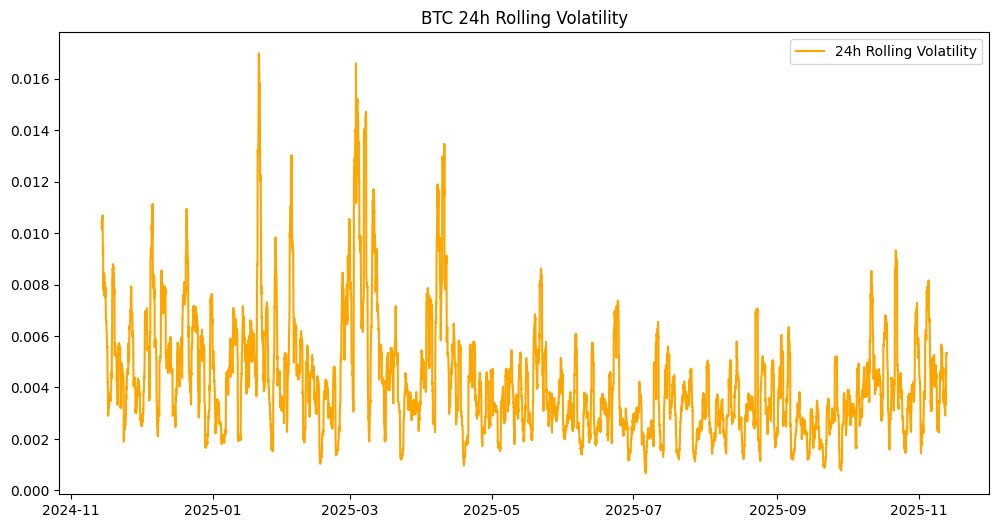

In [4]:
# 24-hour rolling volatility (std of log returns)
btc["rolling_vol"] = btc["log_return"].rolling(24).std()

plt.figure(figsize=(12,6))
plt.plot(btc["rolling_vol"], label="24h Rolling Volatility", color='orange')
plt.title("BTC 24h Rolling Volatility")
plt.legend()
plt.show()


In [5]:
low_th = btc["rolling_vol"].quantile(0.25)
high_th = btc["rolling_vol"].quantile(0.75)

def classify_vol(v):
    if v < low_th:
        return "Low Vol"
    elif v < high_th:
        return "Medium Vol"
    else:
        return "High Vol"

btc["Regime"] = btc["rolling_vol"].apply(classify_vol)
btc[["Close", "rolling_vol", "Regime"]].tail()


Price,Close,rolling_vol,Regime
Ticker,BTC-USD,,
Datetime,,,
2025-11-12 22:00:00+00:00,101944.156250,0.005309,High Vol
2025-11-12 23:00:00+00:00,101650.554688,0.005328,High Vol
2025-11-13 00:00:00+00:00,101831.203125,0.005348,High Vol
2025-11-13 01:00:00+00:00,102002.398438,0.005332,High Vol
2025-11-13 02:00:00+00:00,102048.023438,0.005334,High Vol


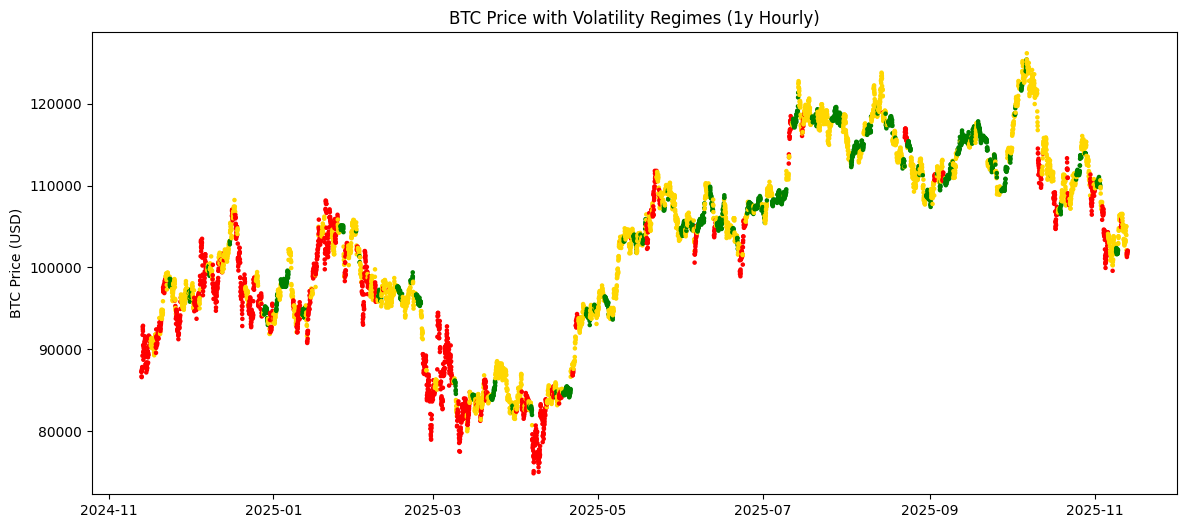

In [6]:
plt.figure(figsize=(14,6))
colors = {"Low Vol": "green", "Medium Vol": "gold", "High Vol": "red"}
plt.scatter(btc.index, btc["Close"], c=btc["Regime"].map(colors), s=5)
plt.title("BTC Price with Volatility Regimes (1y Hourly)")
plt.ylabel("BTC Price (USD)")
plt.show()


In [7]:
summary = btc["Regime"].value_counts(normalize=True).mul(100).round(2)
pd.DataFrame({
    "Regime": summary.index,
    "Percentage of Time (%)": summary.values
})


,Regime,Percentage of Time (%)
0,Medium Vol,49.86
1,High Vol,25.21
2,Low Vol,24.93


In [8]:
returns = btc["log_return"].dropna() * 100  # GARCH expects % returns
model = arch_model(returns, vol="Garch", p=1, q=1)
res = model.fit(update_freq=10, disp="off")

print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4830.72
Distribution:                  Normal   AIC:                           9669.44
Method:            Maximum Likelihood   BIC:                           9697.75
                                        No. Observations:                 8760
Date:                Thu, Nov 13 2025   Df Residuals:                     8759
Time:                        10:01:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.6125e-03  4.146e-03      0.630      0.529 

| Parameter    | Coefficient         | Interpretation                                               |
| ------------ | ------------------- | ------------------------------------------------------------ |
| **omega**    | Baseline volatility | Constant long-term variance                                  |
| **alpha[1]** | Reaction to shocks  | How strongly new volatility spikes affect current volatility |
| **beta[1]**  | Persistence         | How long volatility lasts before fading                      |


In [9]:
forecast = res.forecast(horizon=24)
vol_forecast = np.sqrt(forecast.variance.iloc[-1]).values

pd.DataFrame({
    "Hour Ahead": range(1,25),
    "Predicted Volatility (%)": vol_forecast
})


,Hour Ahead,Predicted Volatility (%)
0,1,0.370227
1,2,0.381322
2,3,0.391913
3,4,0.402044
4,5,0.411753
5,6,0.421071
6,7,0.430026
7,8,0.438644
8,9,0.446947
9,10,0.454955


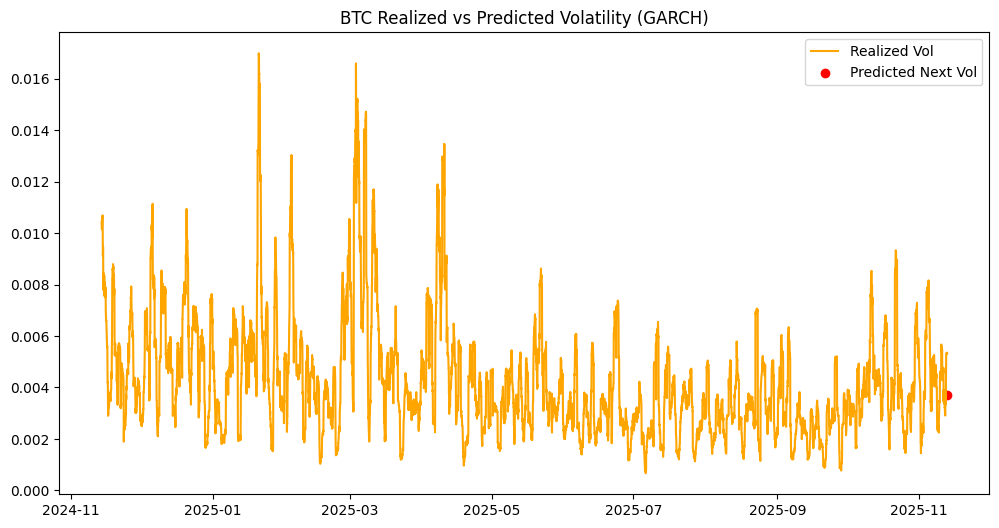

In [10]:
btc["predicted_vol"] = np.nan
btc.loc[returns.index[-1], "predicted_vol"] = vol_forecast[0]

plt.figure(figsize=(12,6))
plt.plot(btc["rolling_vol"], label="Realized Vol", color='orange')
plt.scatter(btc.index[-1], vol_forecast[0]/100, color='red', label="Predicted Next Vol")
plt.title("BTC Realized vs Predicted Volatility (GARCH)")
plt.legend()
plt.show()

| Concept                  | Meaning                      | Crypto Insight                                                       |
| ------------------------ | ---------------------------- | -------------------------------------------------------------------- |
| **Rolling Volatility**   | Measures *recent* turbulence | Crypto shows strong clustering — spikes are frequent but short-lived |
| **Volatility Regimes**   | Classifies calm vs chaos     | Useful for regime-aware strategies (adjust leverage)                 |
| **GARCH Model**          | Predicts future volatility   | Captures persistence — crypto’s “memory” of shocks                   |
| **High Persistence (β)** | Volatility fades slowly      | Means “after a storm, more storms”                                   |
| **Forecast Decay**       | Declining vol forecast       | Market calming down                                                  |
